# Une introduction à `PyTorch` et `autograd`

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
from numpy.random import default_rng
rng = default_rng()

# Feedforward Neural Network (perceptron multicouche)

In [4]:
from matplotlib.lines import Line2D
from matplotlib.patches import Circle, Ellipse

def draw_neural_net(layer_sizes, colors, ratio, delta):
    left, right, bottom, top = delta, 1-delta, delta, 1-delta 
    patches = []
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    diameter = v_spacing/4.
    # Nodes
    for n, (layer_size, c) in enumerate(zip(layer_sizes, colors)):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = Ellipse((n*h_spacing + left, layer_top - m*v_spacing), 
                              width=diameter, height=diameter*ratio,
                              color=c, ec='k', zorder=1)
            patches.append(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                #patches.append(Arrow(0.2, 0.2, 0.3, 0.3, width=0.01))
                line = Line2D([n*h_spacing + left + diameter/2, (n + 1)*h_spacing + left- diameter/2],
                              [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], 
                              color='grey', lw=1, alpha=0.5, zorder=0)
                                       #coordsA = "data", coordsB = "data",
                                  #arrowstyle="-|>")
                patches.append(line)    
    return patches


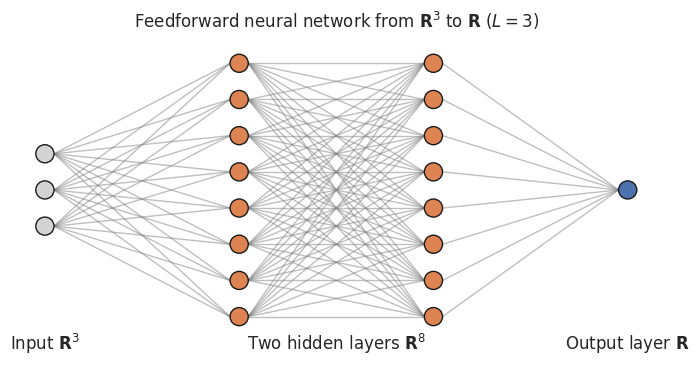

In [5]:
fig, ax = plt.subplots(figsize=(8,4))
size = fig.get_size_inches()*fig.dpi
ratio = size[0] / size[1]
delta = 0.03
patches = draw_neural_net([3, 8, 8, 1], ['lightgrey', 'C1', 'C1', 'C0'], ratio, delta)
for p in patches: 
    ax.add_artist(p)
ax.annotate(r"Input $\mathbf{R}^3$", xy=(delta, 0.), xycoords="data", 
            va="center", ha="center")
ax.annotate(r"Two hidden layers $\mathbf{R}^8$", xy=(0.5, 0.), xycoords="data", 
            va="center", ha="center")
ax.annotate(r"Output layer $\mathbf{R}$", xy=(1-delta, 0.), xycoords="data", 
            va="center", ha="center")
ax.axis('off')
ax.set_title(r"Feedforward neural network from $\mathbf{R}^3$ to $\mathbf{R}$ ($L=3$)")
plt.show()

## Module `torch.nn` et classe `nn.Module` 

**Lire tous les tutoriels:** https://pytorch.org/tutorials/index.html

In [3]:
import torch
from torch import nn

In [4]:
print(dir(nn))

['AdaptiveAvgPool1d', 'AdaptiveAvgPool2d', 'AdaptiveAvgPool3d', 'AdaptiveLogSoftmaxWithLoss', 'AdaptiveMaxPool1d', 'AdaptiveMaxPool2d', 'AdaptiveMaxPool3d', 'AlphaDropout', 'AvgPool1d', 'AvgPool2d', 'AvgPool3d', 'BCELoss', 'BCEWithLogitsLoss', 'BatchNorm1d', 'BatchNorm2d', 'BatchNorm3d', 'Bilinear', 'CELU', 'CTCLoss', 'ChannelShuffle', 'CircularPad1d', 'CircularPad2d', 'CircularPad3d', 'ConstantPad1d', 'ConstantPad2d', 'ConstantPad3d', 'Container', 'Conv1d', 'Conv2d', 'Conv3d', 'ConvTranspose1d', 'ConvTranspose2d', 'ConvTranspose3d', 'CosineEmbeddingLoss', 'CosineSimilarity', 'CrossEntropyLoss', 'CrossMapLRN2d', 'DataParallel', 'Dropout', 'Dropout1d', 'Dropout2d', 'Dropout3d', 'ELU', 'Embedding', 'EmbeddingBag', 'FeatureAlphaDropout', 'Flatten', 'Fold', 'FractionalMaxPool2d', 'FractionalMaxPool3d', 'GELU', 'GLU', 'GRU', 'GRUCell', 'GaussianNLLLoss', 'GroupNorm', 'Hardshrink', 'Hardsigmoid', 'Hardswish', 'Hardtanh', 'HingeEmbeddingLoss', 'HuberLoss', 'Identity', 'InstanceNorm1d', 'Insta

In [21]:
class NeuralNetwork(nn.Module):
    # 3,8 couche neurones de 3 a 8 
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [23]:
from inspect import getsource
print(getsource(nn.Linear))

class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`.

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
   

In [24]:
import torch.nn.functional as F 
print(type(F.linear))
F.linear

<class 'builtin_function_or_method'>


<function torch._C._nn.linear>

## Création d'un objet: une fonction paramétrique

In [19]:
Phi = NeuralNetwork()
print(Phi)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [20]:
x = torch.tensor([0.2, 0.3, 0.4])
Phi(x)  # appel comme une fonction de $\R^3 \to \R$ ou Phi.forward(x)

tensor([-0.0638], grad_fn=<ViewBackward0>)

In [25]:
n = 10 
xx = x.repeat(n, 1)
print(xx.shape)
xx

torch.Size([10, 3])


tensor([[0.2000, 0.3000, 0.4000],
        [0.2000, 0.3000, 0.4000],
        [0.2000, 0.3000, 0.4000],
        [0.2000, 0.3000, 0.4000],
        [0.2000, 0.3000, 0.4000],
        [0.2000, 0.3000, 0.4000],
        [0.2000, 0.3000, 0.4000],
        [0.2000, 0.3000, 0.4000],
        [0.2000, 0.3000, 0.4000],
        [0.2000, 0.3000, 0.4000]])

In [26]:
Phi(xx)  # appel vectoriel comme une fonction de $\R^{n\times3} \to \R^n$

tensor([[-0.0638],
        [-0.0638],
        [-0.0638],
        [-0.0638],
        [-0.0638],
        [-0.0638],
        [-0.0638],
        [-0.0638],
        [-0.0638],
        [-0.0638]], grad_fn=<AddmmBackward0>)

## Accès aux paramètres

In [28]:
for name, param in Phi.named_parameters():
    print(name, "\t", param.size())
# ou for name, param in Phi.state_dict().items():

linear_relu_stack.0.weight 	 torch.Size([8, 3])
linear_relu_stack.0.bias 	 torch.Size([8])
linear_relu_stack.2.weight 	 torch.Size([8, 8])
linear_relu_stack.2.bias 	 torch.Size([8])
linear_relu_stack.4.weight 	 torch.Size([1, 8])
linear_relu_stack.4.bias 	 torch.Size([1])


In [30]:
Phi.get_parameter("linear_relu_stack.0.weight")

Parameter containing:
tensor([[-0.4670,  0.5143,  0.4909],
        [-0.0795,  0.3677, -0.3650],
        [ 0.0964,  0.3638,  0.4541],
        [-0.1277, -0.3996, -0.3701],
        [-0.5277, -0.4701,  0.3136],
        [ 0.4725, -0.2466, -0.2642],
        [-0.0581, -0.0542, -0.1375],
        [ 0.0201,  0.5632,  0.3573]], requires_grad=True)

In [31]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        print("Parameters initialization of", m)
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

Phi.apply(init_weights)

for name, param in Phi.named_parameters():
    print(name, "\t", param)

Parameters initialization of Linear(in_features=3, out_features=8, bias=True)
Parameters initialization of Linear(in_features=8, out_features=8, bias=True)
Parameters initialization of Linear(in_features=8, out_features=1, bias=True)
linear_relu_stack.0.weight 	 Parameter containing:
tensor([[-0.5660, -0.4889,  0.7311],
        [-0.3350,  0.4621, -0.2320],
        [ 0.6714, -0.5640,  0.0569],
        [-0.3066, -0.0612, -0.6189],
        [-0.2556,  0.2081, -0.3649],
        [ 0.1757, -0.0957, -0.3925],
        [ 0.4590,  0.3781, -0.0478],
        [-0.1235, -0.3292,  0.1792]], requires_grad=True)
linear_relu_stack.0.bias 	 Parameter containing:
tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
       requires_grad=True)
linear_relu_stack.2.weight 	 Parameter containing:
tensor([[ 0.5126,  0.5539, -0.5811,  0.3627,  0.1595, -0.1109,  0.3004, -0.3212],
        [-0.4610, -0.1550, -0.1630, -0.3167, -0.5546,  0.1740,  0.0416,  0.5034],
        [-0.5317,  0.4596,  0.3689

In [32]:
Phi(x)

tensor([-0.0221], grad_fn=<ViewBackward0>)

# Outil `autograd`

- https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

In [33]:
from math import pi
xx = torch.linspace(0, 1, 1000)
yy = 0.1 - 0.3*xx + 0.5*xx**2  

In [34]:
yy_with_noise = yy + 0.005 * torch.randn_like(yy)

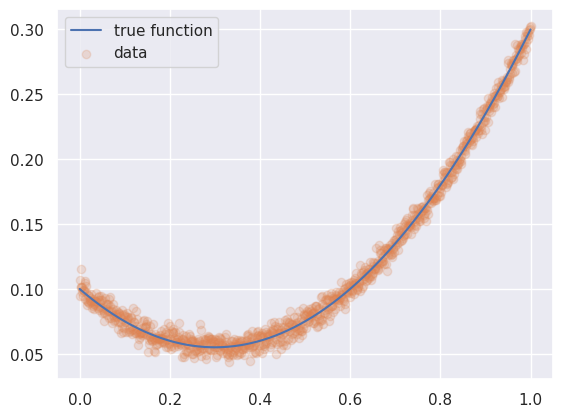

In [35]:
fig, ax = plt.subplots()
ax.plot(xx, yy, label="true function")
ax.scatter(xx, yy_with_noise, label="data", color='C1', alpha=0.2)
ax.legend() 

In [37]:
xx_ = xx[:, None]
bases = torch.cat([torch.ones_like(xx_), xx_, xx_**2], dim=1)

In [38]:
bases.shape

torch.Size([1000, 3])

In [39]:
theta = torch.tensor([0., 0., 0.], requires_grad=True)
loss = ((yy - bases @ theta)**2).mean() #@ multiplication matricielle
loss.backward()   # différentiation automatique "backward" pour calculer le gradient
theta.grad        # on récupère le gradient dans le champ "grad" de la variable paramètre

tensor([-0.2335, -0.1502, -0.1169])

In [40]:
loss

tensor(0.0184, grad_fn=<MeanBackward0>)

In [41]:
# attention: juste pour illustrer la syntaxe! ce n'est pas un gradient stochastique

theta = torch.tensor([0., 0., 0.], requires_grad=True)
for n in range(100000):
    # loss = ((yy - bases @ theta)**2).mean() # sans bruit
    loss = ((yy_with_noise - bases @ theta)**2).mean() # avec bruit
    loss.backward()
    with torch.no_grad():  # on impose à pytorch de pouvoir faire des opérations sans le gradient 
        theta -= 1/(n+1) * theta.grad
    if (n % 10000 == 0):
        print(n, loss.item(), theta)

0 0.018367953598499298 tensor([0.2337, 0.1501, 0.1167], requires_grad=True)
10000 8.427431748714298e-05 tensor([ 0.0982, -0.2720,  0.4844], requires_grad=True)
20000 0.00032790383556857705 tensor([ 0.1093, -0.2641,  0.4703], requires_grad=True)
30000 0.00025581158115528524 tensor([ 0.1021, -0.2374,  0.4438], requires_grad=True)
40000 5.16568252351135e-05 tensor([ 0.1088, -0.3514,  0.5563], requires_grad=True)
50000 0.00010336631385143846 tensor([ 0.1005, -0.2527,  0.4527], requires_grad=True)
60000 4.100282603758387e-05 tensor([ 0.1050, -0.3381,  0.5434], requires_grad=True)
70000 4.576847277348861e-05 tensor([ 0.0872, -0.2479,  0.4538], requires_grad=True)
80000 0.00022071614512242377 tensor([ 0.0968, -0.3508,  0.5458], requires_grad=True)
90000 9.007169865071774e-05 tensor([ 0.0901, -0.2654,  0.4569], requires_grad=True)


## Une fonctionnalité utile moins connue

https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#optional-reading-tensor-gradients-and-jacobian-products

On peut calculer la dérivée d'une fonction en plusieurs points simultanément, il suffit de voir la fonction comme une application de $\mathbf{R}^d$ dans $\mathbf{R}^d$ et de calculer son jacobien. Il faut ajouter un argument dans l'appel de la fonction `backward`.

In [42]:
xx = torch.linspace(0, 2*pi, 1000, requires_grad=True)
yy = torch.sin(xx)
yy.backward(torch.ones_like(yy), retain_graph=True)
with torch.no_grad():
    dyy = xx.grad

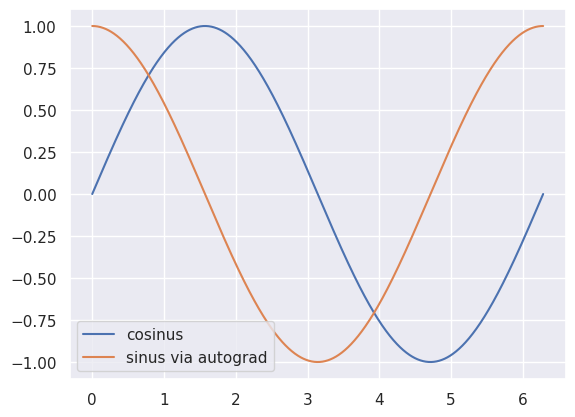

In [43]:
fig, ax = plt.subplots()
with torch.no_grad():
    ax.plot(xx, yy, label="cosinus")
    ax.plot(xx, dyy, label="sinus via autograd")
ax.legend()
plt.show()

In [ ]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)

In [ ]:
inp

In [ ]:
out

In [ ]:
torch.ones_like(out)